# Quickstart Tutorial

## Description

This notebook is taken from the online `eleanor` tutorial https://adina.feinste.in/eleanor/getting_started/tutorial.html.

## Questions:
- Why is the ratio of the radii slightly greater than the square root of the depth? Is it because the planet glows a little?
- How do people put uncertainties on things like the orbital periods? Is there some kind of Lomb-Scargle periodogram statistical test? Or a Monte Carlo simulation?
- What is the difference between the data as handled by `lightkurve` and by `eleanor`? Which should we use?

## 1.1 Fast Light Curves

As a simple first example, we will use $\texttt{eleanor}$ to create a target pixel file (TPF) and light curve for a given TIC target.

In [1]:
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

First, we will load the data for TIC 38846515 (WASP-100), a relatively bright star observed in Sector 1. $\texttt{eleanor}$ is able to extract a light curve easily and automatically for this unblended object. Calling source will assign a $\textit{Gaia}$ DR2 ID, TESS magnitude, sector, camera, ccd, and associated postcard.

In [4]:
star = eleanor.Source(tic=38846515, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.9597092399964, and Dec -64.0270368810381


Here, the software is connecting to the MAST servers to download an $\texttt{eleanor}$ postcard file, postcard background file, and the pointing model for that sector-camera-CCD. A postcard is a 104 $\times$ 148 pixel cutout region of the entire FFI. The postcard background file is a 2D-interpolated background model across the postcard. The pointing model is an additional file created that performs an affine transformation on top of the WCS to ensure the most accurate pixel location of your target is.

If you do not know what sector your target was observed in, calling ```eleanor.Source()``` without a sector keyword passed through explicitly will return the most recent sector for which the star was observed. If you think your target may have been observed in multiple sectors, you may want to consider ```eleanor.multi_sectors()```, as described below.

In addition to passing in a TIC ID, we can also pass through a Simbad-resolvable name, a Gaia DR2 ID, or an RA/Dec pair, either as a tuple or an Astropy SkyCoord object. For example, the following three calls all point to the same target:

In [ ]:
# Optional:

star = eleanor.Source(name='WASP-100', sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

coords = (68.959732, -64.02704)
# or
coords = SkyCoord(ra=68.959732, dec=-64.02704, unit=(u.deg, u.deg))

star = eleanor.Source(coords=coords, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

'''star = eleanor.Source(gaia=4675352109658261376, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))'''

Gaia has quite a bit of precision on the star's position! Now that we have our `Source` information, we simply call the `eleanor.TargetData()` function, which will extract a target pixel file from the postcard, perform aperture photometry, and complete some simple systematics corrections. This function chooses an aperture which optimizes the light curve for transit searches.

We can also set some operations when calling this function. For example, `do_pca = True` tells $\texttt{eleanor}$ to use the cotrending basis vectors on a background subtracted light curve without any additional correction. And `do_psf = True` creates a point spread function modeled light curve of our target.

In addition to automatically choosing an aperture, `eleanor.TargetData()` also tries a few different background subtractions to remove as much background noise as possible. The three options it tries are:

- 1D postcard background : A constant ($3\mu + 2med$) is calculated from each postcard frame

- 1D TPF background : A constant ($3\mu + 2med$) is calculated from each TPF frame 

- 2D background : The 2D background pixels are subtracted from the TPF
    
For both 1D options, stars are masked before estimating the background value.

In [5]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

100%|██████████| 1282/1282 [00:17<00:00, 72.07it/s]


Let's look at our new light curves! 

Plotted below are the following:
- Black : the raw light curve (aperture $\times$ TPF + background subtraction)
- Red : the corrected light curve (black light curve + additional corrections)
- Green : the PCA light curve (aperture $\times$ TPF + background subtraction + cotrending basis vectors)
- Blue : the PSF modeled light curve
    

Before plotting, we can use quality flags to mask poor quality data. Our quality flags are taken from the two-minute *TESS* light curves and binned to 30-minutes. We are very generous with our masking, so any flag that applies to the entire FFI is marked in `data.quality`. We also introduce our own quality flag for when the pointing model significantly deviates from a best-fit line in the sector (see Figure 2 in Feinstein et al. 2019).

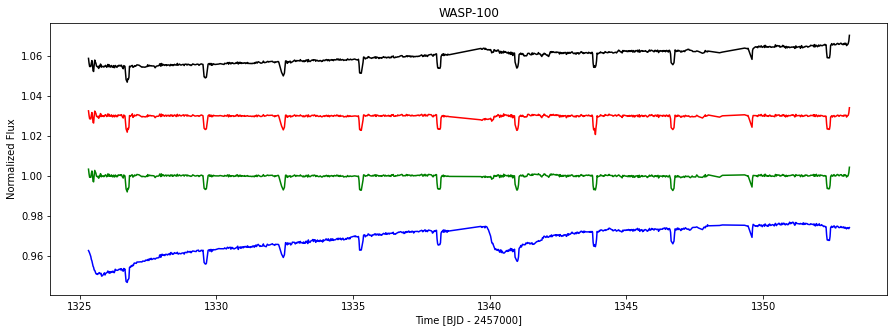

In [96]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.03, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('WASP-100');

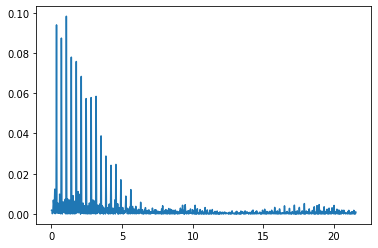

In [97]:
FREQUENCY_INDEX_LIMIT = 3000

frequency, power = LombScargle(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q])).autopower()
plt.plot(frequency[:FREQUENCY_INDEX_LIMIT], power[:FREQUENCY_INDEX_LIMIT])

In [105]:
PEAK_CUTOFF = 0.02

def getPeriod(f, p):
    period = 0
    sumWeights = 0
    for i in range(len(p)):
        if p[i] > PEAK_CUTOFF:
            period += 1/f[i] * (p[i] - PEAK_CUTOFF)
            sumWeights += (p[i] - PEAK_CUTOFF)
        if p[i] < PEAK_CUTOFF and period > 0:
            period /= sumWeights
            return period

print("Period: {0}.".format(getPeriod(frequency, power)))

Period: 2.8280835195271474.


There's a planet there! 

For this star, we found the postcard level 1D background did a good job at removing additional noise in the data. We can check which background model was used by calling:

In [7]:
data.bkg_type

'TPF_2D_LEVEL'

We can even plot the background as a function of time to see what was removed from our light curve. All three background models are saved and can be called by the following:

- 1D postcard background : data.bkg_type = 'PC_LEVEL' : keyword = data.flux_bkg

- 1D TPF background : data.bkg_type = 'TPF_LEVEL' : keyword = data.tpf_flux_bkg

- 2D TPF backround : data.bkg_type = 'TPF_2D_LEVEL' : keyword = data.bkg_tpf


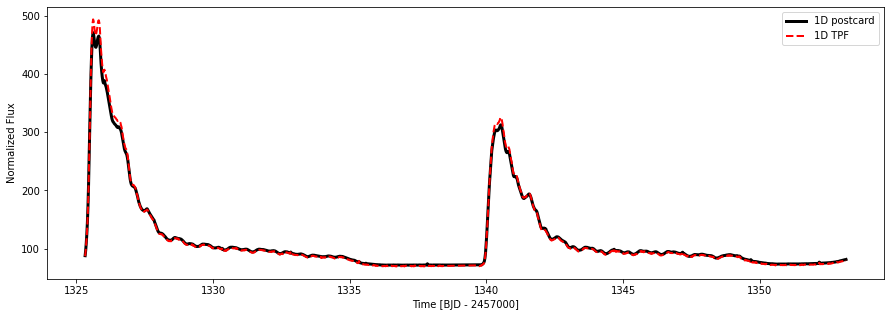

In [8]:
plt.figure(figsize=(15,5))

plt.plot(data.time, data.flux_bkg, 'k', label='1D postcard', linewidth=3)
plt.plot(data.time, data.tpf_flux_bkg, 'r--', label='1D TPF', linewidth=2)
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

And to see what a frame of the 2D background looks like, we can plot it as

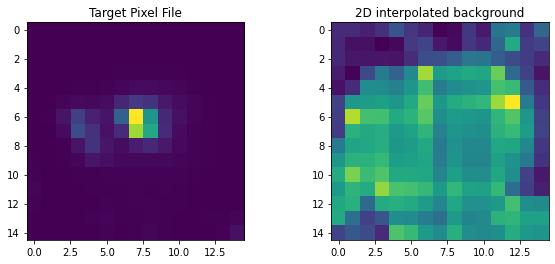

In [106]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');

What does our automatically chosen aperture look like? And how does it compare to where the star falls on the TPF?

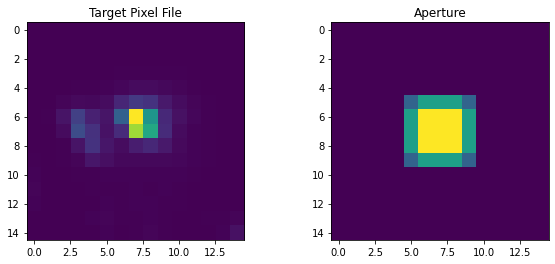

In [107]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.aperture)
ax2.set_title('Aperture');

Let's save these data to a FITS file so we have them later. By default, this will be saved to a `~/.eleanor` directory, but that can be changed by setting a `directory`.

In [11]:
data.save()

With one line of code, we can pass this through as a [lightkurve](https://github.com/KeplerGO/lightkurve) object and begin using the functionality of that package. 

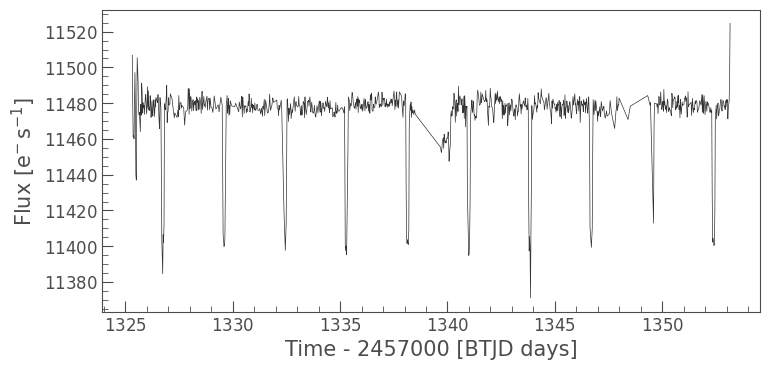

In [10]:
lk = data.to_lightkurve()
lk.plot()

## Data analysis

I would like to measure the period of the star and the transit depth. First, we will plot a Lomb-Scargle periodogram of the lightcurve.

Properties we would like to measure:
- Period: 2.849 days
- Depth: 0.76% $\implies$ radii ratio: 0.1106

### Period
I'd like to measure the period of the star. We will take the first spike of the L-S Pgram.

lightkurve.Periodogram properties:
      Attribute           Description        Units    
---------------------- ------------------ ------------
                nterms                  1             
          default_view          frequency             
             ls_method               fast             
              targetid           38846515             
frequency_at_max_power             1.0491        1 / d
             max_power             7.4165 electron / s
               nyquist            23.9997        1 / d
   period_at_max_power             0.9532            d
             frequency      array (3340,)        1 / d
                period      array (3340,)            d
                 power      array (3340,) electron / s
                 label <class 'NoneType'>             
                  meta     <class 'dict'>             


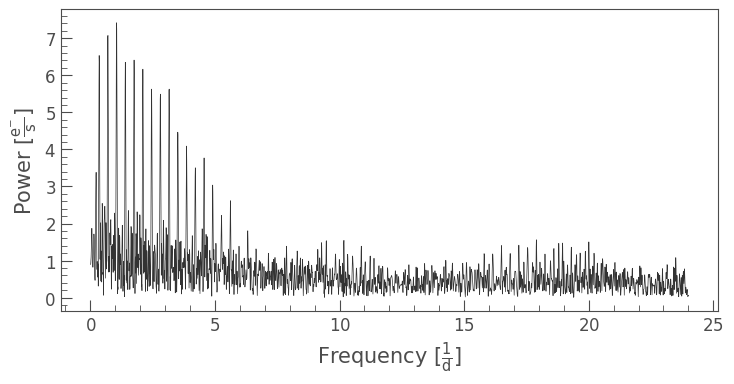

In [33]:
from lightkurve.periodogram import LombScarglePeriodogram
from astropy.units import Quantity

pg = LombScarglePeriodogram.from_lightcurve(lk)
pg.plot()

pg.show_properties()

Take the first peak, which is the fundamental frequency.

In [78]:
PEAK_CUTOFF = Quantity(4, pg.power[0].unit)

def getPeriod(pg):
    period = 0
    sumWeights = 0
    for i in range(len(pg.power)):
        if pg.power[i] > PEAK_CUTOFF:
            period += pg.period[i] * (pg.power[i] - PEAK_CUTOFF).value
            sumWeights += (pg.power[i] - PEAK_CUTOFF).value
        if pg.power[i] < PEAK_CUTOFF and period > 0:
            period /= sumWeights
            return period

print("Period: {0}.".format(getPeriod(pg)))

Period: 2.826204383604723 d.


### Depth:

Find the depth of the lightcurve

In [81]:
from math import sqrt

FLUX_CUTOFF = 11420

def getDepth(lk):
    peaks = []# time, depth
    thisTime = 0
    thisSumWeights = 0
    thisMinFlux = -1
    numNormal = 0
    sumNormal = 0
    for i in range(len(lk.flux)):
        if lk.flux[i] < FLUX_CUTOFF:
            if thisTime == 0:
                thisMinFlux = lk.flux[i]
            thisTime += lk.time[i] * (FLUX_CUTOFF - lk.flux[i])
            thisSumWeights += (FLUX_CUTOFF - lk.flux[i])
            thisMinFlux = min(thisMinFlux, lk.flux[i])
        else:
            sumNormal += lk.flux[i]
            numNormal += 1
            if thisTime > 0:
                thisTime /= thisSumWeights
                peaks.append((thisTime, thisMinFlux))
                thisTime = 0
                thisSumWeights = 0
                thisMinFlux = -1
    
    mean = sumNormal / numNormal
    sumDepths = 0
    nCounted = 0
    for time, height in peaks:
        sumDepths += mean - height
        nCounted += 1
    sumDepths /= nCounted
    return sumDepths / mean

depth = getDepth(lk)
print("Depth: {0}.".format(depth))
print("Radii ratio: {0}.".format(sqrt(depth)))

Depth: 0.007134572986852755.
Radii ratio: 0.08446640152659965.


## 1.2 Stars Observed in Multiple Sectors

$\texttt{eleanor}$ has some built-in tools to make it easier to work with stars that are observed in multiple TESS sectors. Let's consider WASP-100 again, which was observed in both Sectors 1 and 2. When we previously called `eleanor.Source()`, we can instead call `eleanor.multi_sectors()`, which will make a list of Source objects for all sectors requested.

In [13]:
star = eleanor.multi_sectors(tic=38846515, sectors=[1,2])

INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /home/jtdinsmo/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  2...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acqui

In this case, I only wanted sectors 1 and 2. However, I could have passed through `sectors='all'` to get all sectors in which this star was observed.

In [14]:
print(star)

[<eleanor.source.Source object at 0x7fcc69372ac8>, <eleanor.source.Source object at 0x7fcd26d0af60>]


Yep, it's a list of objects!
We can then call `eleanor.TargetData()` on each.

Loading file hlsp_eleanor_tess_ffi_tic38846515_s01_tess_v1.0.5_lc.fits found on disk


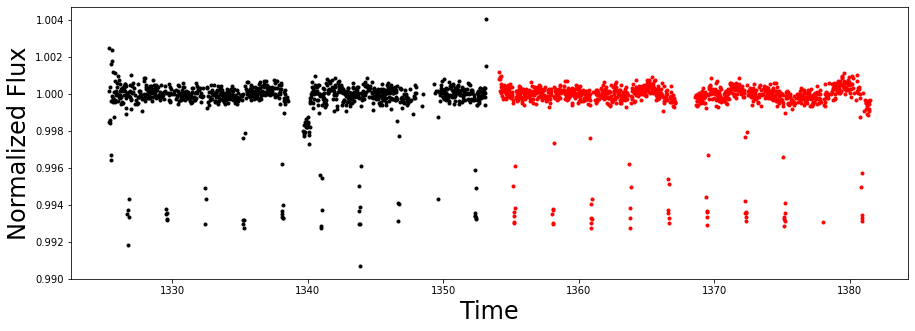

In [16]:
plt.figure(figsize=(15,5))

data = []
plot_fmt = ['k.', 'r.']

for s in star:   
    datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31, do_psf=False, do_pca=False)
    data.append(datum)
    
for sector, datum in enumerate(data):
    q = datum.quality == 0
    plt.plot(datum.time[q], datum.corr_flux[q]/np.median(datum.corr_flux[q]), plot_fmt[sector])

plt.ylabel('Normalized Flux', fontsize=24)
plt.xlabel('Time', fontsize=24)

plt.show()

If you are only interested in one Sector your star was observed in, you can call `eleanor.Source(sector=1)` and specify the Sector you are interested in. If your star was observed in multiple sectors and you call `eleanor.Source()`, it will return the light curve from the most recent Sector the star was observed in.

## 1.3 Good practices

We're still exploring what the best practices are generally. Good practices seem to differ across the detector, but here's what we believe so far. If you discover anything that works well for you, we and other $\texttt{eleanor}$ users would surely love to know them! You can also find some tips, tricks, and hacks in the next example notebook.

Good background subtraction is very important. The size of the region to use for an "ideal" background changes across the detector. Generally, bigger is better, we typically recommend using a region larger than the standard TPF. Currently, the background used must be a rectangle centered on the star, with size `bkg_size`.

PSF modeling (`do_psf=True`) seems to work very well for relatively bright, isolated stars. Presently the only PSF models usable are Gaussian and Moffat profiles. Both Gaussian and Poisson likelihood functions are possible as well. Do note that this requires tensorflow<2.0. Note that PSF modeling is very much in beta and our current implementation has known issues for very faint stars (fainter than I ~ 15, generally). 

If you find anything that works well for your science, or uncover any issues, please let us know! Github [issues](https://github.com/afeinstein20/eleanor/issues) or [pull requests](https://github.com/afeinstein20/eleanor/pulls) are welcomed.